# Adding activity chains to synthetic populations 

The purpose of this script is to match each individual in the synthetic population to a respondant from the [National Travel Survey (NTS)](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340). 

### Methods

We will try two methods

1. categorical matching: joining on relevant socio-demographic variables
2. statistical matching, as described in [An unconstrained statistical matching algorithm for combining individual and household level geo-specific census and survey data](https://doi.org/10.1016/j.compenvurbsys.2016.11.003). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from acbm.preprocessing import (
    count_per_group,
    nts_filter_by_region,
    nts_filter_by_year,
    num_adult_child_hh,
    transform_by_group,
    truncate_values,
)

## Step 1: Load in the datasets  

### SPC 

In [2]:
# useful variables
region = "west-yorkshire"

In [3]:
# Read in the spc data (parquet format)
spc = pd.read_parquet('../data/spc_output/' + region + '_people_hh.parquet')
spc.head()

,id,household,workplace,location,events,weekday_diaries,weekend_diaries,orig_pid,id_tus_hh,id_tus_p,...,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8
0,0,0,NaN,"{'x': -1.7892179489135742, 'y': 53.91915130615...","{'concert_f': 1.2791347489984115e-31, 'concert...","[1583, 13161]","[1582, 13160]",E02002183_0001_001,11291218,1,...,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0
1,1,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 9.743248151956307e-21, 'concert_...","[2900, 4948, 4972, 7424, 10284, 10586, 12199, ...","[2901, 4949, 4973, 7425, 10285, 10585, 12198, ...",E02002183_0002_001,17291219,1,...,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0
2,2,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 8.46716103992468e-16, 'concert_f...","[3010, 6389, 9448, 10184, 11598]","[3011, 6388, 9447, 10183, 11599]",E02002183_0002_002,17070713,2,...,3.0,NaN,6.0,True,2.0,2,2,68,1,2.0
3,3,2,56126.0,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 1.8844366073608398, 'concert_fs'...","[366, 867, 2096, 3678, 5212, 5450, 8145, 9254,...","[365, 868, 2097, 3677, 5213, 5451, 8146, 9253,...",E02002183_0003_001,20310313,1,...,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0
4,4,2,NaN,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 4.877435207366943, 'concert_fs':...","[1289, 12528, 12870]","[1288, 12529, 12871]",E02002183_0003_002,13010909,3,...,3.0,NaN,6.0,True,2.0,1,2,26,1,6.0


In [4]:
# temporary reduction of the dataset for quick analysis
spc = spc.head(5000)

In [5]:
spc.columns

Index(['id', 'household', 'workplace', 'location', 'events', 'weekday_diaries',
       'weekend_diaries', 'orig_pid', 'id_tus_hh', 'id_tus_p', 'pid_hs',
       'msoa', 'oa', 'members', 'bmi', 'has_cardiovascular_disease',
       'has_diabetes', 'has_high_blood_pressure', 'number_medications',
       'self_assessed_health', 'life_satisfaction', 'sic1d2007', 'sic2d2007',
       'soc2010', 'pwkstat', 'salary_yearly', 'salary_hourly', 'hid',
       'accommodation_type', 'communal_type', 'num_rooms', 'central_heat',
       'tenure', 'num_cars', 'sex', 'age_years', 'ethnicity', 'nssec8'],
      dtype='object')

### NTS

The NTS is split up into multiple tables. We will load in the following tables:
- individuals
- households
- trips

In [6]:
# path where datasets are stored
path_psu = "../data/nts/UKDA-5340-tab/tab/psu_eul_2002-2022.tab"
psu = pd.read_csv(path_psu, sep="\t")

path_individuals = "../data/nts/UKDA-5340-tab/tab/individual_eul_2002-2022.tab"
nts_individuals = pd.read_csv(path_individuals, sep="\t")

path_households = "../data/nts/UKDA-5340-tab/tab/household_eul_2002-2022.tab"
nts_households = pd.read_csv(path_households, sep="\t")

path_trips = "../data/nts/UKDA-5340-tab/tab/trip_eul_2002-2022.tab"
nts_trips = pd.read_csv(path_trips, sep="\t")


#### Filter by year

We will filter the NTS data to only include data from specific years. We can choose only 1 year, or multiple years to increase our sample size and the likelihood of a match with the spc

In [7]:
years = [2019, 2021, 2022]

nts_individuals_filtered = nts_filter_by_year(nts_individuals, psu, years)
nts_households_filtered = nts_filter_by_year(nts_households, psu, years)
nts_trips_filtered = nts_filter_by_year(nts_trips, psu, years)



#### Filter by geography 

I will not do this for categorical matching, as it reduces the sample significantly, and leads to more spc households not being matched

In [8]:
# regions = ['Yorkshire and the Humber', 'North West']

# nts_individuals_filtered = nts_filter_by_region(nts_individuals_filtered, psu, regions)
# nts_households_filtered = nts_filter_by_region(nts_households_filtered, psu, regions)
# nts_trips_filtered = nts_filter_by_region(nts_trips_filtered, psu, regions)


Create dictionaries of key value pairs

In [9]:
'''
guide to the dictionaries:

_nts_hh: from NTS households table
_nts_ind: from NTS individuals table
_spc: from SPC

'''


# ---------- NTS

# Create a dictionary for the HHIncome2002_B02ID column
income_dict_nts_hh = {
     '1': '0-25k',
     '2': '25k-50k',
     '3': '50k+',
    '-8': 'NA',
    # should be -10, but
    # it could be a typo in household_eul_2002-2022_ukda_data_dictionary
    '-1': 'DEAD'
}

# Create a dictionary for the HHoldEmploy_B01ID column
# (PT: Part time, FT: Full time)
employment_dict_nts_hh = {
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'
}

# Create a dictionary for the Ten1_B02ID column
tenure_dict_nts_hh = {
    '1': 'Owns / buying',
    '2': 'Rents',
    '3': 'Other (including rent free)',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# ---------- SPC


# create a dictionary for the pwkstat column
employment_dict_spc = {
    '0': 'Not applicable (age < 16)',
    '1': 'Employee FT',
    '2': 'Employee PT',
    '3': 'Employee unspecified',
    '4': 'Self-employed',
    '5': 'Unemployed',
    '6': 'Retired',
    '7': 'Homemaker/Maternal leave',
    '8': 'Student',
    '9': 'Long term sickness/disability',
    '10': 'Other'
}


# Create a dictionary for the tenure column
tenure_dict_spc = {
    '1': 'Owned: Owned outright',
    '2': 'Owned: Owned with a mortgage or loan or shared ownership',
    '3': 'Rented or living rent free: Total',
    '4': 'Rented: Social rented',
    '5': 'Rented: Private rented or living rent free',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# Combine the dictionaries into a dictionary of dictionaries

dict_nts = {
    'HHIncome2002_B02ID': income_dict_nts_hh,
    'HHoldEmploy_B01ID': employment_dict_nts_hh,
    'Ten1_B02ID': tenure_dict_nts_hh
}

dict_spc = {
    'pwkstat': employment_dict_spc,
    'tenure': tenure_dict_spc
}



## Step 2: Decide on matching variables  

We need to identify the socio-demographic characteristics that we will match on. The schema for the synthetic population can be found [here](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto). 

Matching between the SPC and the NTS will happen in two steps: 

1. Match at the household level
2. Match individuals within the household

### Household level matching 

| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Household income   | `HHIncome2002_BO2ID` | `salary_yearly` | NA                   | Group by household ID and sum |
| Number of adults   | `HHoldNumAdults`        | `age_years`     | NA                   | Group by household ID and count |
| Number of children | `HHoldNumChildren`      | `age_years`     | NA                   | Group by household ID and count |
| Employment status  | `HHoldEmploy_B01ID`  | `pwkstat`       | NA                   | a) match to NTS categories. b) group by household ID |
| Car ownership      | `NumCar`             | `num_cars`      | SPC is capped at 2. We change all entries > 2 to 2 | NA  |

Other columns to match in the future
| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Type of tenancy    | `Ten1_B02ID`         | `tenure`        | ?? | ?? |
|  Urban-Rural classification of residence | `Settlement2011EW_B04ID`         | NA     | NA            | Spatial join between [layer](https://www.gov.uk/government/collections/rural-urban-classification) and SPC  |



### 2.1 Edit SPC columns 

#### Household Income

Edit the spc so that we have household income as well as individual income.

In [10]:
# add household income column for SPC
spc_edited = transform_by_group(data = spc,
                                group_col = 'household',
                                transform_col = 'salary_yearly',
                                new_col = 'salary_yearly_hh',
                                transformation_type = 'sum')


Check number of individuals and households with reported salaries

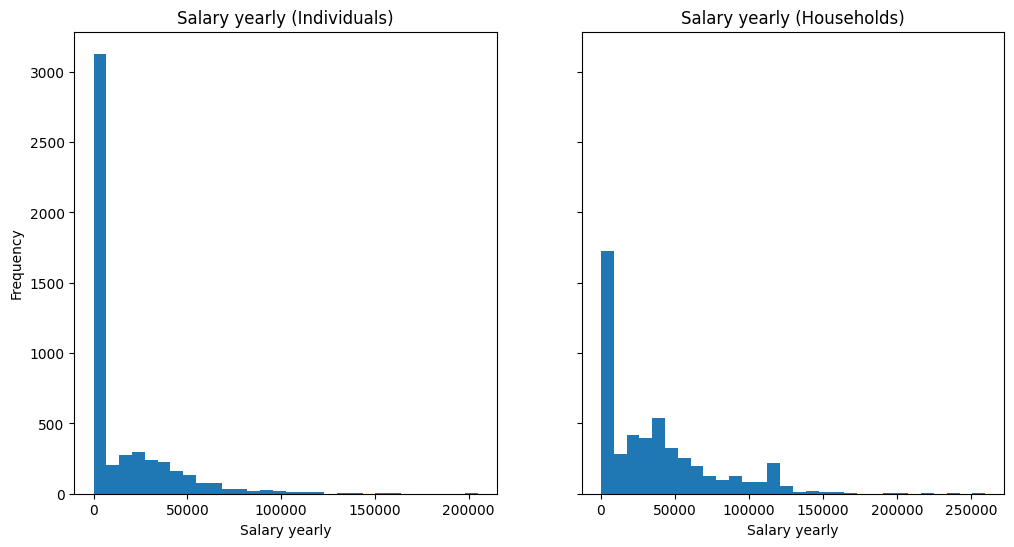

Individuals in SPC = 5000
Individuals without reported income = 3029
% of individuals with reported income = 39.4
Households in SPC = 2373
Households without reported income = 1577
% of households with reported income = 66.5


In [11]:
# histogram for individuals and households (include NAs as 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].hist(spc_edited['salary_yearly'].fillna(0), bins=30)
ax[0].set_title('Salary yearly (Individuals)')
ax[0].set_xlabel('Salary yearly')
ax[0].set_ylabel('Frequency')
ax[1].hist(spc_edited['salary_yearly_hh'].fillna(0), bins=30)
ax[1].set_title('Salary yearly (Households)')
ax[1].set_xlabel('Salary yearly')
plt.show()


# statistics

# print the total number of rows in the spc. Add a message "Values ="
print("Individuals in SPC =", spc_edited.shape[0])
# number of individuals without reported income
print("Individuals without reported income =", spc_edited['salary_yearly'].isna().sum())
# % of individuals with reported income (salary_yearly not equal NA)
print("% of individuals with reported income =", round((spc_edited['salary_yearly'].count() / spc_edited.shape[0]) * 100, 1))

# print the total number of households
print("Households in SPC =", spc_edited['household'].nunique())
# number of households without reported income (salary yearly_hh = 0)
print("Households without reported income =", spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0])
# # % of households with reported income (salary_yearly not equal NA)
print("% of households with reported income =", round((spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0] / spc_edited['household'].nunique()) * 100, 1))

In [12]:


# --- Recode column so that it matches the reported NTS values (Use income_dict_nts_hh dictionary for reference)

# Define the bins
bins = [0, 24999, 49999, np.inf]
# Define the labels for the bins
labels = [1, 2, 3]

spc_edited = spc_edited.copy()

spc_edited['salary_yearly_hh_cat'] = (pd.cut(spc_edited['salary_yearly_hh'], bins=bins, labels=labels)
                                       .astype('str')
                                       .astype('float'))


# replace NA values with -8 (to be consistent with NTS)
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].fillna(-8)

# Convert the column to int
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].astype('int')


#### Household Composition (No. of Adults / Children)

In [13]:
# Number of adults and children in the household

spc_edited = num_adult_child_hh(data = spc_edited,
                                group_col = 'household',
                                age_col = 'age_years')

#### Employment Status

In [14]:
# Employment status

# check the colums values from our dictionary
dict_spc['pwkstat'], dict_nts['HHoldEmploy_B01ID']

({'0': 'Not applicable (age < 16)',
  '1': 'Employee FT',
  '2': 'Employee PT',
  '3': 'Employee unspecified',
  '4': 'Self-employed',
  '5': 'Unemployed',
  '6': 'Retired',
  '7': 'Homemaker/Maternal leave',
  '8': 'Student',
  '9': 'Long term sickness/disability',
  '10': 'Other'},
 {'1': 'None',
  '2': '0 FT, 1 PT',
  '3': '1 FT, 0 PT',
  '4': '0 FT, 2 PT',
  '5': '1 FT, 1 PT',
  '6': '2 FT, 0 PT',
  '7': '1 FT, 2+ PT',
  '8': '2 FT, 1+ PT',
  '9': '0 FT, 3+ PT',
  '10': '3+ FT, 0 PT',
  '11': '3+ FT, 1+ PT',
  '-8': 'NA',
  '-10': 'DEAD'})

The NTS only reports the number of Full time and Part time employees for each household. For the SPC we also need to get the number of full time and part time workers for each household.

Step 1: Create a column for Full time and a column for Part time

In [15]:
# We will only use '1' and '2' for the employment status

counts_df = count_per_group(df = spc_edited,
                            group_col = 'household',
                            count_col = 'pwkstat',
                            values=[1, 2],
                            value_names=['pwkstat_FT_hh','pwkstat_PT_hh'])

counts_df.head(10)

,pwkstat_FT_hh,pwkstat_PT_hh
household,,
0,0,0
1,0,0
2,2,0
3,1,0
4,0,0
5,1,0
6,0,0
7,1,0
8,1,0


Create a column that matches the NTS categories (m FT, n PT)

In [16]:
# We want to match the SPC values to the NTS
dict_nts['HHoldEmploy_B01ID']
'''
{
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'}
 '''

# 1) Match each row to the NTS

# Define the conditions and outputs.
# We are using the keys in dict_nts['HHoldEmploy_B01ID'] as reference
conditions = [
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 2),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] >= 2),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] >= 1),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] >= 3),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] >= 1)
]

# Define the corresponding outputs based on dict_nts['HHoldEmploy_B01ID]
outputs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Create a new column using np.select
counts_df['pwkstat_NTS_match'] = np.select(conditions,
                                           outputs,
                                           default= -8)



# 2) merge back onto the spc
spc_edited = spc_edited.merge(counts_df, left_on='household', right_index=True)

# check the output
spc_edited[['household', 'pwkstat', 'pwkstat_FT_hh', 'pwkstat_PT_hh', 'pwkstat_NTS_match']].head(10)


,household,pwkstat,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match
0,0,6,0,0,1
1,1,6,0,0,1
2,1,6,0,0,1
3,2,1,2,0,6
4,2,1,2,0,6
5,3,1,1,0,3
6,4,10,0,0,1
7,4,4,0,0,1
8,4,0,0,0,1
9,5,1,1,0,3


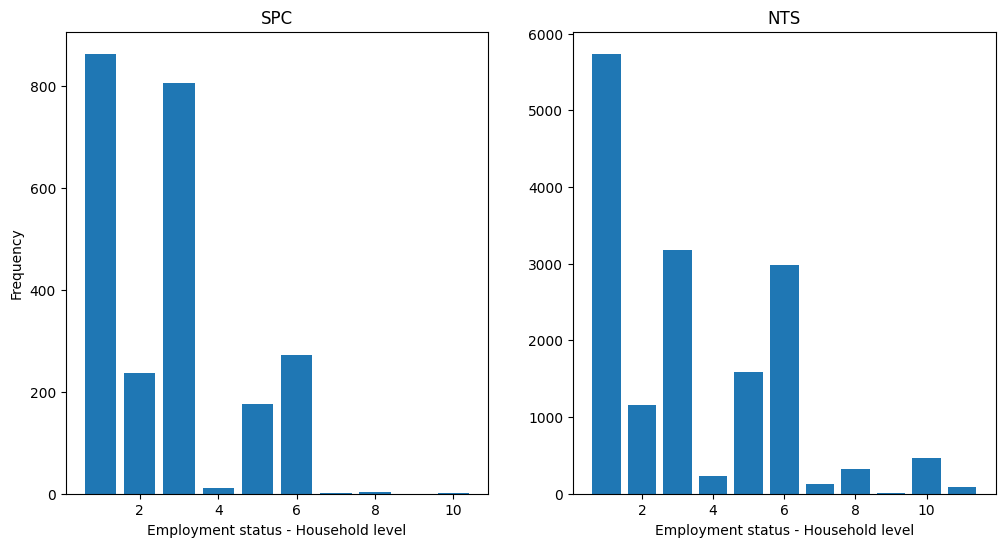

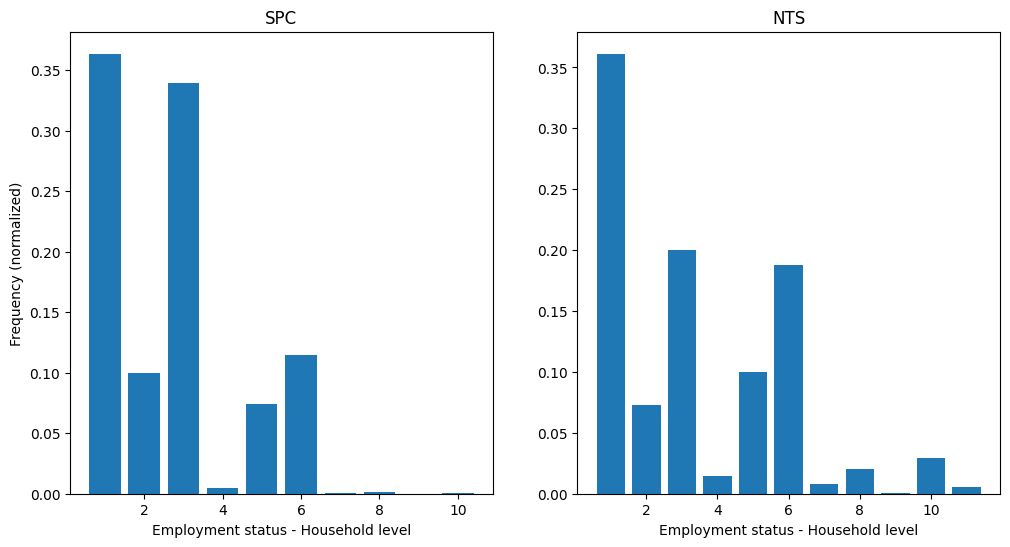

In [17]:
# bar plot of counts_df['pwkstat_NTS_match'] and nts_households_filtered['HHoldEmploy_B01ID']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts().values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency')
ax[1].bar(nts_households_filtered['HHoldEmploy_B01ID'].value_counts().index, nts_households_filtered['HHoldEmploy_B01ID'].value_counts().values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()

# same as above but percentages
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts(normalize=True).values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency (normalized)')
ax[1].bar(nts_households_filtered['HHoldEmploy_B01ID'].value_counts().index, nts_households_filtered['HHoldEmploy_B01ID'].value_counts(normalize=True).values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()



### 2.2 Edit NTS columns

#### Number of cars

- `SPC.num_cars` only has values [0, 1, 2]. 2 is for all households with 2 or more cars
- `NTS.NumCar` is more detailed. It has the actual value of the number of cars. We will cap this at 2.

In [18]:

# Create a new column in NTS
nts_households_filtered.loc[:, 'NumCar_SPC_match'] = nts_households_filtered['NumCar'].apply(truncate_values, upper = 2)

nts_households_filtered[['NumCar', 'NumCar_SPC_match']].head(20)

/tmp/ipykernel_1071464/1336610326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nts_households_filtered.loc[:, 'NumCar_SPC_match'] = nts_households_filtered['NumCar'].apply(truncate_values, upper = 2)


,NumCar,NumCar_SPC_match
142954,1.0,1.0
142955,1.0,1.0
142956,0.0,0.0
142957,2.0,2.0
142958,1.0,1.0
142959,1.0,1.0
142960,2.0,2.0
142961,1.0,1.0
142962,2.0,2.0
142963,1.0,1.0


#### Type of tenancy

Breakdown between NTS and SPC is different. 

In [19]:
dict_nts['Ten1_B02ID'], dict_spc['tenure']

({'1': 'Owns / buying',
  '2': 'Rents',
  '3': 'Other (including rent free)',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'},
 {'1': 'Owned: Owned outright',
  '2': 'Owned: Owned with a mortgage or loan or shared ownership',
  '3': 'Rented or living rent free: Total',
  '4': 'Rented: Social rented',
  '5': 'Rented: Private rented or living rent free',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'})

Create dictionaries to map tenure onto the spc and nts dfs

In [20]:
# Dictionary showing how we want the final columns to look like
tenure_dict_nts_spc = {
    1: 'Owned',
    2: 'Rented or rent free',
    -8: 'NA',
    -9: 'DNA',
    -10: 'DEAD'
}

# Matching NTS to tenure_dict_nts_spc

# Create a new dictionary for matching
matching_dict_nts_tenure = {
    1: 1,
    2: 2,
    3: 2
}

matching_dict_spc_tenure = {
    1: 1, #'Owned: Owned outright' : 'Owned'
    2: 1, #'Owned: Owned with a mortgage or loan or shared ownership', : 'Owned'
    3: 2, #'Rented or living rent free: Total', : 'Rented or rent free'
    4: 2, #'Rented: Social rented', : 'Rented or rent free'
    5: 2, #'Rented: Private rented or living rent free', : 'Rented or rent free'
}



map dictionaries to create comparable columns

In [21]:
# Create a new column in nts_households_filtered
nts_households_filtered['tenure_nts_for_matching'] = (nts_households_filtered['Ten1_B02ID']
                                                    .map(matching_dict_nts_tenure) # map the values to the new dictionary
                                                    .fillna(nts_households_filtered['Ten1_B02ID'])) # fill the NaNs with the original values

# Create a new column in spc
spc_edited['tenure_spc_for_matching'] = (spc_edited['tenure']
                                        .map(matching_dict_spc_tenure) # map the values to the new dictionary
                                        .fillna(spc_edited['tenure'])) # fill the NaNs with the original values

/tmp/ipykernel_1071464/3351388236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nts_households_filtered['tenure_nts_for_matching'] = (nts_households_filtered['Ten1_B02ID']


## Step 3: Matching at Household Level

Now that we've prepared all the columns, we can start matching.

### 3.1 Categorical matching

We will match on (a subset of) the following columns:

| Matching variable | NTS column | SPC column |
| ------------------| ---------- | ---------- |
| Household income  | `HHIncome2002_BO2ID` | `salary_yearly_hh_cat` |
| Number of adults  | `HHoldNumAdults` | `num_adults` |
| Number of children | `HHoldNumChildren` | `num_children` |
| Employment status | `HHoldEmploy_B01ID` | `pwkstat_NTS_match` |
| Car ownership | `NumCar_SPC_match` | `num_cars` |
| Type of tenancy | `tenure_nts_for_matching` | `tenure_spc_for_matching` |

Prepare SPC df for matching

In [22]:
# Select multiple columns
spc_matching = spc_edited[[
    'hid',
    'salary_yearly_hh_cat', 'num_adults',
    'num_children', 'pwkstat_NTS_match',
    'num_cars', 'tenure_spc_for_matching']]

# edit the df so that we have one row per hid
spc_matching = spc_matching.drop_duplicates(subset='hid')

spc_matching.head(10)

,hid,salary_yearly_hh_cat,num_adults,num_children,pwkstat_NTS_match,num_cars,tenure_spc_for_matching
0,E02002183_0001,-8,1,0,1,2,1.0
1,E02002183_0002,-8,2,0,1,2,1.0
3,E02002183_0003,3,2,0,6,1,1.0
5,E02002183_0004,2,1,0,3,1,1.0
6,E02002183_0005,-8,2,1,1,2,1.0
9,E02002183_0006,3,1,0,3,1,2.0
10,E02002183_0007,-8,2,1,1,1,1.0
13,E02002183_0008,2,1,0,3,2,1.0
14,E02002183_0009,1,2,0,3,2,1.0
16,E02002183_0010,1,2,1,2,2,1.0


In [112]:
spc_matching.shape

(2373, 7)

Prepare NTS df for matching

In [23]:
nts_matching = nts_households_filtered[[
    'HouseholdID','HHIncome2002_B02ID',
    'HHoldNumAdults', 'HHoldNumChildren',
    'HHoldEmploy_B01ID', 'NumCar_SPC_match',
    'tenure_nts_for_matching']]

nts_matching.head(10)

,HouseholdID,HHIncome2002_B02ID,HHoldNumAdults,HHoldNumChildren,HHoldEmploy_B01ID,NumCar_SPC_match,tenure_nts_for_matching
142954,2019001895,1.0,3,0,1,1.0,1.0
142955,2019002676,1.0,1,0,3,1.0,1.0
142956,2019001891,1.0,2,0,1,0.0,2.0
142957,2019002687,2.0,4,0,4,2.0,2.0
142958,2019001913,1.0,1,0,3,1.0,1.0
142959,2019002273,2.0,1,0,3,1.0,2.0
142960,2019001906,3.0,3,0,5,2.0,1.0
142961,2019001910,1.0,2,0,1,1.0,1.0
142962,2019002688,3.0,2,2,6,2.0,1.0
142963,2019002686,1.0,2,0,2,1.0,1.0


Dictionary of matching columns. We extract column names from this dictioary when matching on a subset of the columns

In [104]:
# column_names (keys) for the dictionary
matching_ids = ['household_id', 'yearly_income', 'number_adults', 'number_children', 'employment_status', 'number_cars', 'tenure_status']

# i want the value to be a list with spc_matching and nts_matching
matching_dfs_dict = {column_name: [spc_value, nts_value] for column_name, spc_value, nts_value in zip(matching_ids, spc_matching, nts_matching)}
matching_dfs_dict

{'household_id': ['hid', 'HouseholdID'],
 'yearly_income': ['salary_yearly_hh_cat', 'HHIncome2002_B02ID'],
 'number_adults': ['num_adults', 'HHoldNumAdults'],
 'number_children': ['num_children', 'HHoldNumChildren'],
 'employment_status': ['pwkstat_NTS_match', 'HHoldEmploy_B01ID'],
 'number_cars': ['num_cars', 'NumCar_SPC_match'],
 'tenure_status': ['tenure_spc_for_matching', 'tenure_nts_for_matching']}

Attempt 1: Match on all possible columns

Text(0.5, 1.0, 'Categorical Matching')

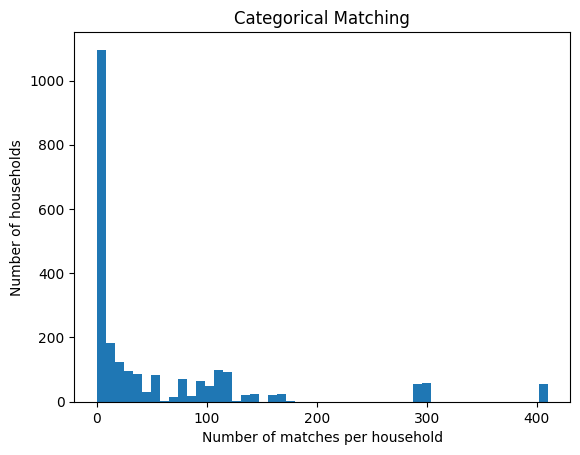

In [130]:
# columns for matching 
keys = ['yearly_income', 'number_adults', 'number_children', 'employment_status', 'number_cars', 'tenure_status']


spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# match
spc_nts_1 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_1['count'] = spc_nts_1.groupby('hid')['HouseholdID'].transform('count')

spc_nts_1_hist = spc_nts_1.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_1_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')

Attempt 2: Match on a subset of columns (exclude salary)

Text(0.5, 1.0, 'Categorical Matching')

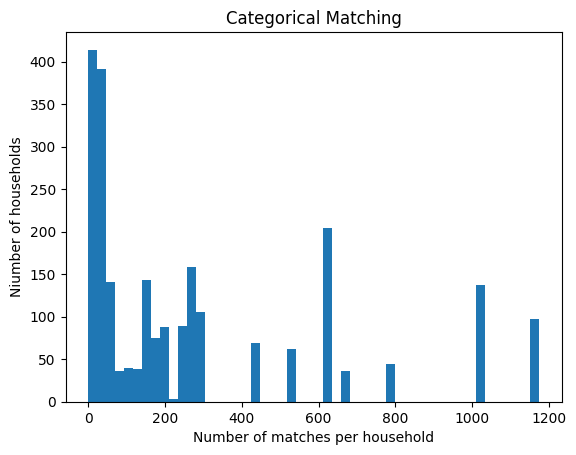

In [117]:
# columns for matching
keys = ['number_adults', 'number_children', 'employment_status', 'number_cars', 'tenure_status']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# matc
spc_nts_2 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_2['count'] = spc_nts_2.groupby('hid')['HouseholdID'].transform('count')

spc_nts_2_hist = spc_nts_2.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_2_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Niumber of households')
plt.title('Categorical Matching')

Attempt 3: Match on a subset of columns (exclude salary and tenure)

Text(0.5, 1.0, 'Categorical Matching')

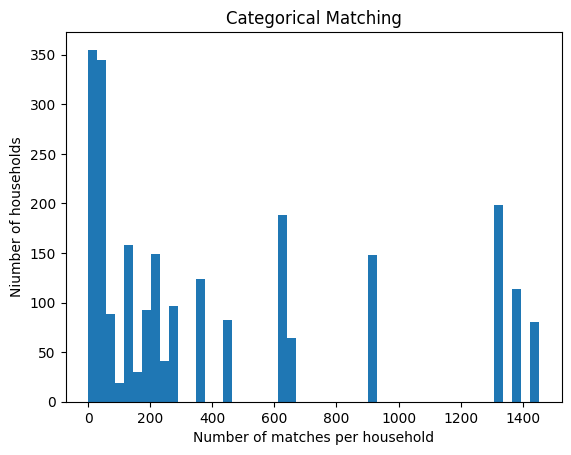

In [131]:

# columns for matching
keys = ['number_adults', 'number_children', 'employment_status', 'number_cars']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# matc
spc_nts_3 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_3['count'] = spc_nts_3.groupby('hid')['HouseholdID'].transform('count')

spc_nts_3_hist = spc_nts_3.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_3_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Niumber of households')
plt.title('Categorical Matching')


Attempt 4: Match on a subset of columns (exclude salary, tenure, and employment status)

Text(0.5, 1.0, 'Categorical Matching')

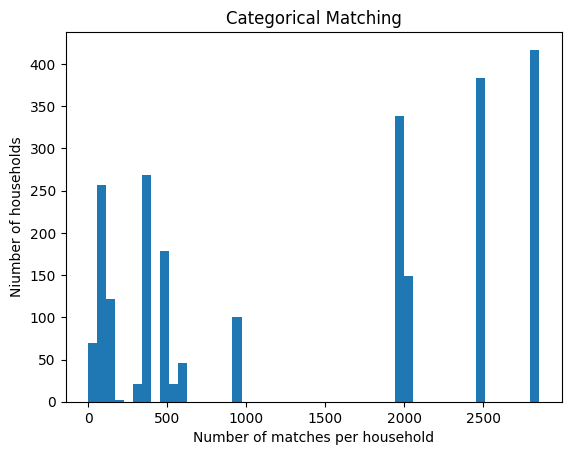

In [132]:

# columns for matching
keys = ['number_adults', 'number_children', 'number_cars']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# matc
spc_nts_4 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_4['count'] = spc_nts_4.groupby('hid')['HouseholdID'].transform('count')

spc_nts_4_hist = spc_nts_4.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_4_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Niumber of households')
plt.title('Categorical Matching')


Removing salary has a significant impact on matching

In [136]:
# Attempt 1
print(spc_nts_1_hist[spc_nts_1_hist['count'] == 0].shape[0], "Unmatched households - matching on all categories")
# Attempt 2
print(spc_nts_2_hist[spc_nts_2_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary from matching")
# Attempt 3
print(spc_nts_3_hist[spc_nts_3_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary and Tenure from matching")
# Attempt 4
print(spc_nts_4_hist[spc_nts_4_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary, Tenure and Employment status from matching")

531 Unmatched households - matching on all categories
34 Unmatched households - exclusing Salary from matching
20 Unmatched households - exclusing Salary and Tenure from matching
4 Unmatched households - exclusing Salary, Tenure and Employment status from matching


Check how many households from the NTS matched onto each SPC household

In [137]:
# how many rows in spc_matching were not matched onto any rows in nts_matching?
spc_nts_1_hist['count'].value_counts()
# calculate th percentage of rows in spc_matching that were not matched onto any rows in nts_matching
# round the result to 2 decimal places
spc_nts_1_hist['count'].value_counts(normalize=True).round(2)
# plot a histogram of the counts, and add a line for the mean value
#spc_nts_hist['count'].plot(kind='hist', bins=100)



count
0      0.22
1      0.10
4      0.06
2      0.05
116    0.03
       ... 
68     0.00
131    0.00
24     0.00
27     0.00
87     0.00
Name: proportion, Length: 78, dtype: float64

Store the results in a dictionary, 

- Key: SPC hid
- Value: List of NTS Household IDs



In [ ]:
# Each hid in spc_matching is joined onto multiple HouseholdID in nts_matching.
# Create a dictionary to store the hid to HouseholdID matches

# Initialize an empty dictionary
hid_to_HouseholdID = {}

# Loop through the DataFrame
for index, row in spc_nts.iterrows():
    # Get the hid and HouseholdID from the row
    hid = row['hid']
    HouseholdID = row['HouseholdID']

    # If the hid is already a key in the dictionary, append the HouseholdID to its list
    if hid in hid_to_HouseholdID:
        hid_to_HouseholdID[hid].append(HouseholdID)
    # If the hid is not a key in the dictionary, add it with a new list that contains the HouseholdID
    else:
        hid_to_HouseholdID[hid] = [HouseholdID]


In [ ]:
# Check the first 10 entries in the dictionary
#list(hid_to_HouseholdID.items())[:100]

# access all the values for a specific key in the dictionary
hid_to_HouseholdID['E02002183_0010']



In [ ]:
# for each key in the dictionary, sample 1 of the values associated with it and store it in a new dictionary

'''
- iterate over each key-value pair in the hid_to_HouseholdID dictionary.
- For each key-value pair, use np.random.choice(value) to randomly select 
one item from the list of values associated with the current key.
- create a new dictionary hid_to_HouseholdID_sample where each key from the 
original dictionary is associated with one randomly selected value from the 
original list of values.

'''
hid_to_HouseholdID_sample = {key: np.random.choice(value) for key, value in hid_to_HouseholdID.items()}


In [ ]:
# same logic as cell above, but repeat it multiple times and store each result as a separate dictionary in a list
hid_to_HouseholdID_sample_list = [{key: np.random.choice(value) for key, value in hid_to_HouseholdID.items()} for i in range(100)]

In [ ]:
# identify the datatype of hid_to_HouseholdID_sample_list
type(hid_to_HouseholdID_sample_list), type(hid_to_HouseholdID_sample)